In [1]:
# Import libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load bike rental and station data CSV files
bike_raw = pd.read_csv("seoul_bike_rental_data_2406.csv", encoding="cp949")
station_raw = pd.read_csv('seoul_bike_station_master_data.csv', encoding="cp949")

# Print dimensions of the two datasets
print(bike_raw.shape)
print()
print(station_raw.shape)

(5004330, 17)

(3340, 5)


In [57]:
# Create a copy of bike rental data for processing
bike_dat = bike_raw.copy()

# Rename and translate columns in bike rental data
bike_dat.rename(
    columns={
        '자전거번호': 'bike_id',
        '대여일시': 'rent_datetime',
        '대여 대여소번호': 'rent_station_number',
        '대여 대여소명': 'rent_station_name',
        '대여거치대': 'rent_station_hold',
        '반납일시': 'return_datetime',
        '반납대여소번호': 'return_station_number',
        '반납대여소명': 'return_station_name',
        '반납거치대': 'return_station_hold',
        '이용시간(분)': 'use_minutes',
        '이용거리(M)': 'use_meters',
        '생년': 'user_birth_year',
        '성별': 'user_sex',
        '이용자종류': 'user_type',
        '대여대여소ID': 'rent_station_id',
        '반납대여소ID': 'return_station_id',
        '자전거구분': 'bike_type',
    },
    inplace=True
)

# Replace invalid values with NA
bike_dat.replace('\\N', pd.NA, inplace=True)

# Add rental and return date and time variables 
bike_dat['rent_datetime'] = pd.to_datetime(bike_dat['rent_datetime'])
bike_dat['rent_date'] = bike_dat['rent_datetime'].dt.date
bike_dat['rent_hour'] = bike_dat['rent_datetime'].dt.hour
bike_dat['rent_weekday'] = bike_dat['rent_datetime'].dt.weekday
bike_dat['rent_is_weekend'] = bike_dat['rent_weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

bike_dat['return_datetime'] = pd.to_datetime(bike_dat['return_datetime'])
bike_dat['return_date'] = bike_dat['return_datetime'].dt.date
bike_dat['return_hour'] = bike_dat['return_datetime'].dt.hour
bike_dat['return_weekday'] = bike_dat['return_datetime'].dt.weekday
bike_dat['return_is_weekend'] = bike_dat['return_weekday'].apply(lambda x: 1 if x in [5, 6] else 0)

In [59]:
# Create a copy of station data for processing
station_info = station_raw.copy()

# Rename and translate columns in station data for consistency and readability
station_info.rename(
    columns={
        '대여소_ID': 'station_id',
        '주소1': 'address_1',
        '주소2': 'address_2',
        '위도': 'station_latitude',
        '경도': 'station_longitude',
    },
    inplace=True
)

# Replace invalid values with NA
station_info.replace('\\N', pd.NA, inplace=True)

# Assert that station IDs are unique in the station data
assert all(station_info['station_id'].value_counts() == 1)

In [61]:
# Merge station information into bike rental data for both rental and return stations
rent_station_info = station_info[['station_id', 'station_latitude', 'station_longitude']].rename(
    columns={
        'station_id': 'rent_station_id',
        'station_latitude': 'rent_station_latitude',
        'station_longitude': 'rent_station_longitude',
    })

return_station_info = station_info[['station_id', 'station_latitude', 'station_longitude']].rename(
    columns={
        'station_id': 'return_station_id',
        'station_latitude': 'return_station_latitude',
        'station_longitude': 'return_station_longitude',
    })

bike_dat = bike_dat.merge(rent_station_info, how='left', on='rent_station_id')
bike_dat = bike_dat.merge(return_station_info, how='left', on='return_station_id')

In [63]:
# Identify missing station information in the bike rental data
print(bike_dat['rent_station_latitude'].isnull().value_counts())
print()
print(bike_dat['return_station_latitude'].isnull().value_counts())

# Remove rides with missing return information - not returned or software errors (19,978 rows)
bike_dat = bike_dat[bike_dat['return_station_id'].isnull() == False]

False    5004330
Name: rent_station_latitude, dtype: int64

False    4984352
True       19978
Name: return_station_latitude, dtype: int64


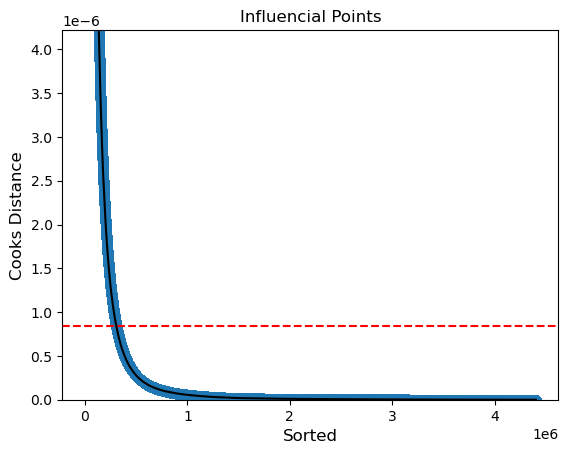

In [65]:
# Detect and remove potential outliers based on used meters and minutes using Cook's distance
# remove 0 minutes or 0 meter riden
bike_dat = bike_dat[(bike_dat['use_meters']!=0) & (bike_dat['use_minutes']!=0)]

y = ((bike_dat['rent_station_latitude']-bike_dat['return_station_latitude'])**2 + (bike_dat['rent_station_longitude']-bike_dat['return_station_longitude'])**2)**0.5
x = bike_dat[['use_meters', 'use_minutes']]

x = sm.add_constant(x)

model = sm.OLS(y.astype(float), x.astype(float)).fit()

np.set_printoptions(suppress=True)
influence = model.get_influence()
cooks = influence.cooks_distance

cooks_df = pd.DataFrame({'row': bike_dat.index, 'cooks_distance': cooks[0]})
sorted_cooks = cooks_df.sort_values(by='cooks_distance', ascending=False)
sorted_cooks['rank'] = sorted_cooks['cooks_distance'].rank(method='dense', ascending=False).astype(int)

# threshold, 4/n
cooks_threshold = 4 / len(bike_dat)

plt.axhline(y=cooks_threshold, color='red', linestyle='--')
plt.scatter(sorted_cooks['rank'], sorted_cooks['cooks_distance'])
plt.plot(sorted_cooks['rank'], sorted_cooks['cooks_distance'], color='black')

plt.ylim([0, cooks_threshold*5])
plt.xlabel('Sorted', fontsize = 12)
plt.ylabel('Cooks Distance', fontsize = 12)
plt.title('Influencial Points', fontsize = 12)
plt.show()

In [67]:
# Remove remove potential outliers based on used meters and minutes using Cook's distance (308,218 rows, ~6.5% of data)
print((cooks_df['cooks_distance'] > cooks_threshold).value_counts())

bike_dat = bike_dat[cooks[0] < cooks_threshold]

False    4432075
True      308218
Name: cooks_distance, dtype: int64


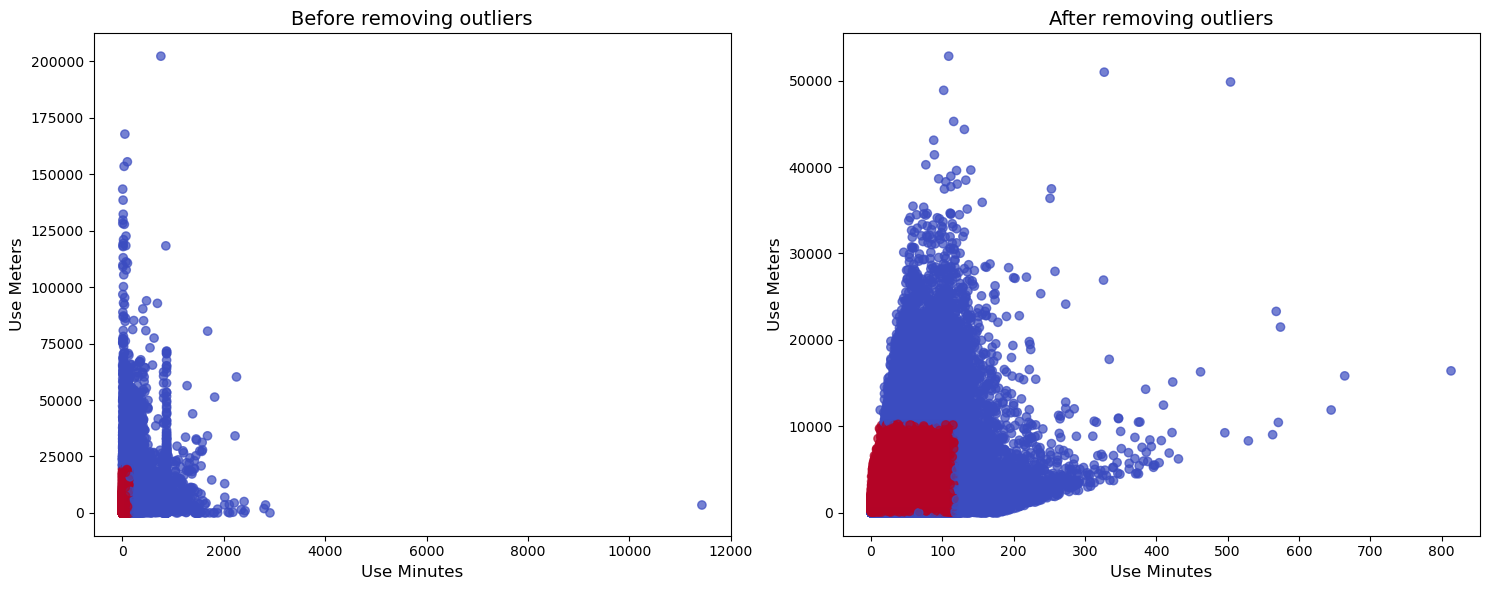

In [69]:
# Compare before and after removing the outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# color-code for middle 99% of data
minutes_low, minutes_high = np.percentile(bike_dat['use_minutes'], [0.5, 99.5])
meters_low, meters_high = np.percentile(bike_dat['use_meters'], [0.5, 99.5])

color_within = (
    (bike_dat['use_minutes'] >= minutes_low) & (bike_dat['use_minutes'] <= minutes_high) &
    (bike_dat['use_meters'] >= meters_low) & (bike_dat['use_meters'] <= meters_high)
)

minutes_low_raw, minutes_high_raw = np.percentile(bike_raw['이용시간(분)'], [0.5, 99.5])
meters_low_raw, meters_high_raw = np.percentile(bike_raw['이용거리(M)'], [0.5, 99.5])

color_within_raw = (
    (bike_raw['이용시간(분)'] >= minutes_low_raw) & (bike_raw['이용시간(분)'] <= minutes_high_raw) &
    (bike_raw['이용거리(M)'] >= meters_low_raw) & (bike_raw['이용거리(M)'] <= meters_high_raw)
)

axes[0].scatter(bike_raw['이용시간(분)'], bike_raw['이용거리(M)'], c=color_within_raw, cmap='coolwarm', alpha=0.7)
axes[0].set_title('Before removing outliers', fontsize=14)
axes[0].set_xlabel('Use Minutes', fontsize=12)
axes[0].set_ylabel('Use Meters', fontsize=12)

axes[1].scatter(bike_dat['use_minutes'], bike_dat['use_meters'], c=color_within, cmap='coolwarm', alpha=0.7)
axes[1].set_title('After removing outliers', fontsize=14)
axes[1].set_xlabel('Use Minutes', fontsize=12)
axes[1].set_ylabel('Use Meters', fontsize=12)


plt.tight_layout()
plt.show()

In [71]:
# Limit use_minutes by maximum of 300 minutes, 30km
bike_dat = bike_dat[bike_dat['use_minutes']<300]
bike_dat = bike_dat[bike_dat['use_meters']<30000]

In [73]:
# Re-assign numeric identifiers for rental stations from 0 to N
bike_dat = bike_dat.drop(['rent_station_number', 'return_station_number'], axis=1)

station_number = np.concatenate([bike_dat['rent_station_id'].drop_duplicates(), bike_dat['return_station_id'].drop_duplicates()])
station_number = pd.Series(station_number).drop_duplicates().astype('category')
station_number = pd.DataFrame({'station_id': station_number, 'station_number': station_number.cat.codes})

bike_dat = bike_dat.merge(station_number.rename(columns={'station_id': 'rent_station_id', 'station_number': 'rent_station_number'}), how = 'left', on = 'rent_station_id')
bike_dat = bike_dat.merge(station_number.rename(columns={'station_id': 'return_station_id', 'station_number': 'return_station_number'}), how = 'left', on = 'return_station_id')

# Assert that station numbers and IDs are uniquely matched
station_list = pd.concat([
    bike_dat[['rent_station_number', 'rent_station_id']].rename(columns={'rent_station_number': 'station_number','rent_station_id' : 'station_id'}), 
    bike_dat[['return_station_number', 'return_station_id']].rename(columns={'return_station_number': 'station_number','return_station_id' : 'station_id'})], ignore_index=True).drop_duplicates()

assert all(station_list['station_number'].value_counts() == 1)
assert all(station_list['station_id'].value_counts() == 1)

In [75]:
# Calculate numbers of unique bikes and rental stations
unique_stations = np.concatenate([bike_dat['rent_station_id'].drop_duplicates(), bike_dat['return_station_id'].drop_duplicates()])
unique_stations = np.unique(unique_stations)
unique_bikes = bike_dat['bike_id'].drop_duplicates()

num_unique_stations = len(unique_stations)
num_unique_bikes = len(unique_bikes)
num_rides = len(bike_dat)

print(f"Seould City's public bike rental system operated {num_rides:,} complete rides with {num_unique_bikes:,} bikes and {num_unique_stations:,} rental stations across the city in June 2024.")

Seould City's public bike rental system operated 4,431,917 complete rides with 39,162 bikes and 2,740 rental stations across the city in June 2024.


In [77]:
bike_dat.sample(n=10, random_state=2024)

,bike_id,rent_datetime,rent_station_name,rent_station_hold,return_datetime,return_station_name,return_station_hold,use_minutes,use_meters,user_birth_year,...,return_date,return_hour,return_weekday,return_is_weekend,rent_station_latitude,rent_station_longitude,return_station_latitude,return_station_longitude,rent_station_number,return_station_number
832616,SPB-65412,2024-06-06 08:47:08,청소년수련관 후문,0,2024-06-06 08:59:00,KT 전화국 버스정류장 옆,0,11,1821.24,1999,...,2024-06-06,8,3,0,37.639664,127.060417,37.654701,127.063400,1525,2376
1109220,SPB-84234,2024-06-08 00:25:38,사당역10번출구(금강빌딩),99,2024-06-08 00:33:46,이수역 11번출구쪽,99,8,940.00,1994,...,2024-06-08,0,5,1,37.479107,126.981506,37.485508,126.981621,1182,2665
4081283,SPB-50607,2024-06-27 22:30:55,엘아르베뉴 102동 앞,0,2024-06-27 22:39:23,독산역1번출구 B,0,8,929.65,1989,...,2024-06-27,22,3,0,37.474525,126.887077,37.467094,126.889206,2046,1448
3692503,SPB-60802,2024-06-25 18:08:20,문정 법조단지8,0,2024-06-25 18:52:21,성내어울터,0,44,6967.81,1982,...,2024-06-25,18,1,0,37.481537,127.122124,37.536556,127.125534,2649,41
690556,SPB-59204,2024-06-05 10:39:07,마곡13단지 정문 앞,0,2024-06-05 11:12:19,마곡역교차로,0,33,2131.70,1968,...,2024-06-05,11,2,0,37.558632,126.819916,37.558311,126.826523,934,56
234672,SPB-55294,2024-06-02 17:36:25,창동역 1번출구 앞,0,2024-06-02 18:01:28,창포원 남쪽 입구,0,25,4299.87,1993,...,2024-06-02,18,6,1,37.653736,127.049294,37.688267,127.048897,1533,965
3595979,SPB-68719,2024-06-25 07:56:43,LG 사이언스파크,0,2024-06-25 07:59:15,마곡나루역 2번 출구,0,2,560.00,1997,...,2024-06-25,7,1,0,37.562550,126.827438,37.566925,126.827438,627,915
2189584,SPB-66329,2024-06-15 04:01:45,거여역 8번출구 뒤,0,2024-06-15 04:09:50,송파파크데일 2단지입구 앞 주차장,0,8,2430.00,1970,...,2024-06-15,4,5,1,37.493126,127.143822,37.495659,127.157173,2639,350
4182729,SPB-65195,2024-06-28 16:50:47,강북문화정보도서관,0,2024-06-28 17:35:10,한내 행복발전소 옆,0,44,5670.00,1963,...,2024-06-28,17,4,0,37.625526,127.037323,37.627411,127.062141,994,1598
4187505,SPB-53995,2024-06-28 17:36:21,잠실주공 521동 건너편,0,2024-06-28 17:56:39,석촌호수 서호 사거리,0,20,1668.12,2002,...,2024-06-28,17,4,0,37.511841,127.095688,37.506561,127.096558,2330,505


In [ ]:
# Export and save processed bike rental data to a CSV file
bike_dat.to_csv('seoul_bike_rental_data_processed_2406.csv', index=False, encoding="cp949") 